In [1]:
import os
from itertools import count

import shapefile
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames
import momepy
import math
import shapely
shapely.speedups.disable()

DATA = "data"

/home/asia/.pyenv/versions/3.8.0/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
G = nx.read_gpickle(os.path.join(DATA, "spiw_peripheral_bike_and_investmap.gpickle"))
G=G.to_undirected()

In [3]:
for u, v, data in G.edges(data=True):
    if data["type"]=='closest_crossing':
        data["type"]='all_road'
    data["bike_counter"]=0


In [4]:
buildings=[node for node in G.nodes if G.nodes[node]["type"]=="building"]

In [5]:
bike_crossings=[node for node in G.nodes if G.nodes[node]["type"]=="bike_crossing"]

In [6]:
H = nx.Graph(((u, v, e) for u,v,e in G.edges(data=True) if e['type'] == 'all_road'))

In [7]:
def path_length(G, path): 
    return sum([list(dict(G[path[i]][path[i+1]]).values())[0]['length'] for i in range(len(path)-1)])

In [8]:
for u,v,e in G.edges(data=True):
    if e['type'] == 'bike_path':
        pt1=shapely.geometry.Point(G.nodes[u]['x'],G.nodes[u]['y'] )
        pt2=shapely.geometry.Point(G.nodes[v]['x'],G.nodes[v]['y'])
        points_df = geopandas.GeoDataFrame({'geometry': [pt1, pt2]}, crs='EPSG:4326').to_crs("EPSG:2177")
        e["length"]=points_df.distance(points_df.shift())[1]
#         print(points_df.distance(points_df.shift())[1])


In [9]:
path_from_building_to_bike_lengths = []


for b in tqdm(buildings):
    shortest_paths=nx.shortest_path(G, source=b,  weight='length') 
#     not_bike=[node for node in shortest_paths.keys() if G.nodes[node]["type"]!="bike_crossing" and G.nodes[node].get("additional")!="new_bike_path"]
    not_bike=[node for node in shortest_paths.keys() if G.nodes[node]["type"]!="bike_crossing"]

    for n in not_bike:
        shortest_paths.pop(n, None)
    shortest_path=(math.inf, math.inf)
    for key, shortest_tmp in shortest_paths.items():
        shortest_length=path_length(G,shortest_tmp)
        if shortest_length<shortest_path[1]:
            shortest_path=(shortest_tmp,shortest_length)
            
    path_from_building_to_bike_lengths.append(shortest_path[1])
    
    for i in range(len(shortest_path[0])-1):
        list(dict(G[shortest_path[0][i]][shortest_path[0][i+1]]).values())[0]['additional']="new_bike_path"
        list(dict(G[shortest_path[0][i]][shortest_path[0][i+1]]).values())[0]['bike_counter']+=1
        G.nodes[shortest_path[0][i]]["additional"]="new_bike_crossing"
        
    G.nodes[shortest_path[0][len(shortest_path[0])-1]]["additional"]="new_bike_crossing"

In [10]:
nx.write_gpickle(G, os.path.join(DATA, "shortest_paths_counter.gpickle")

In [2]:
G = nx.read_gpickle(os.path.join(DATA, "shortest_paths_counter.gpickle"))


In [3]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

In [33]:
G_streets.head()

osmid oneway lanes  ref  \
u        v          key                                
95584835 6152142174 0     28458110   True     2   94   
         4427611763 0     24707867   True     2  NaN   
         3019848617 0     28458112   True     3  395   
         4427611887 0    301726798   True     4   94   
95584841 164895026  0     27665976  False   NaN  NaN   

                                               name       highway maxspeed  \
u        v          key                                                      
95584835 6152142174 0          Aleja Armii Krajowej       primary       50   
         4427611763 0                       Bardzka      tertiary       50   
         3019848617 0                       Bardzka     secondary       50   
         4427611887 0          Aleja Armii Krajowej       primary       50   
95584841 164895026  0    Biskupa Bernarda Bogedaina  unclassified      NaN   

                         length      type  bike_counter  ... access  \
u        v          key                                  ...          
95584835 6152142174 0    12.949  all_road           NaN  ...    NaN   
         4427611763 0    17.930  all_road           NaN  ...    NaN   
         3019848617 0    25.202  all_road           NaN  ...    NaN   
         4427611887 0    31.167  all_road           NaN  ...    NaN   
95584841 164895026  0    14.714  all_road           NaN  ...    NaN   

                        additional bridge junction service width tunnel   x  \
u        v          key                                                       
95584835 6152142174 0          NaN    NaN      NaN     NaN   NaN    NaN NaN   
         4427611763 0          NaN    NaN      NaN     NaN   NaN    NaN NaN   
         3019848617 0          NaN    NaN      NaN     NaN   NaN    NaN NaN   
         4427611887 0          NaN    NaN      NaN     NaN   NaN    NaN NaN   
95584841 164895026  0          NaN    NaN      NaN     NaN   NaN    NaN NaN   

                          y  mm_len  
u        v          key              
95584835 6152142174 0   NaN     NaN  
         4427611763 0   NaN     NaN  
         3019848617 0   NaN     NaN  
         4427611887 0   NaN     NaN  
95584841 164895026  0   NaN     NaN  

[5 rows x 21 columns]

In [23]:
G_streets['bike_counter'] = G_streets['bike_counter'].drop(G_streets['bike_counter'][G_streets['bike_counter']==0].index)

In [40]:
G_streets['bike_counter'].loc[G_streets['bike_counter']>25]

u           v           key
159986328   1004726     0      36.0
            5526393368  0      36.0
159986782   3632716600  0      27.0
246689939   272849144   0      33.0
            268471548   0      33.0
                               ... 
4848249649  5011407007  0      36.0
4848261329  5011407007  0      36.0
5416968818  1003861     0      43.0
5526393368  5526393371  0      36.0
9284004125  9284004127  0      31.0
Name: bike_counter, Length: 74, dtype: float64

In [41]:
G.nodes[272849144]

{'y': 51.104252,
 'x': 16.9472356,
 'street_count': 3,
 'type': 'road_crossing',
 'additional': 'new_bike_crossing'}

1.0     6158
2.0     1457
3.0      553
4.0      402
5.0      193
6.0      180
8.0      126
9.0      116
7.0      100
10.0      94
11.0      41
14.0      39
12.0      27
13.0      26
43.0      19
15.0      19
22.0      15
16.0      14
36.0      13
27.0      12
17.0      12
20.0      12
19.0      10
26.0      10
31.0       9
25.0       8
18.0       7
33.0       6
21.0       5
24.0       3
38.0       3
23.0       1
35.0       1
39.0       1
Name: bike_counter, dtype: int64

(array([32.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.0000e+00, 6.1670e+02, 1.2324e+03, 1.8481e+03, 2.4638e+03,
        3.0795e+03, 3.6952e+03, 4.3109e+03, 4.9266e+03, 5.5423e+03,
        6.1580e+03]),
 <BarContainer object of 10 artists>)

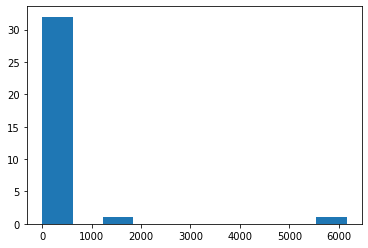

In [25]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 5):
    display(G_streets['bike_counter'].value_counts(dropna=True))
plt.hist(G_streets['bike_counter'].value_counts(dropna=True))

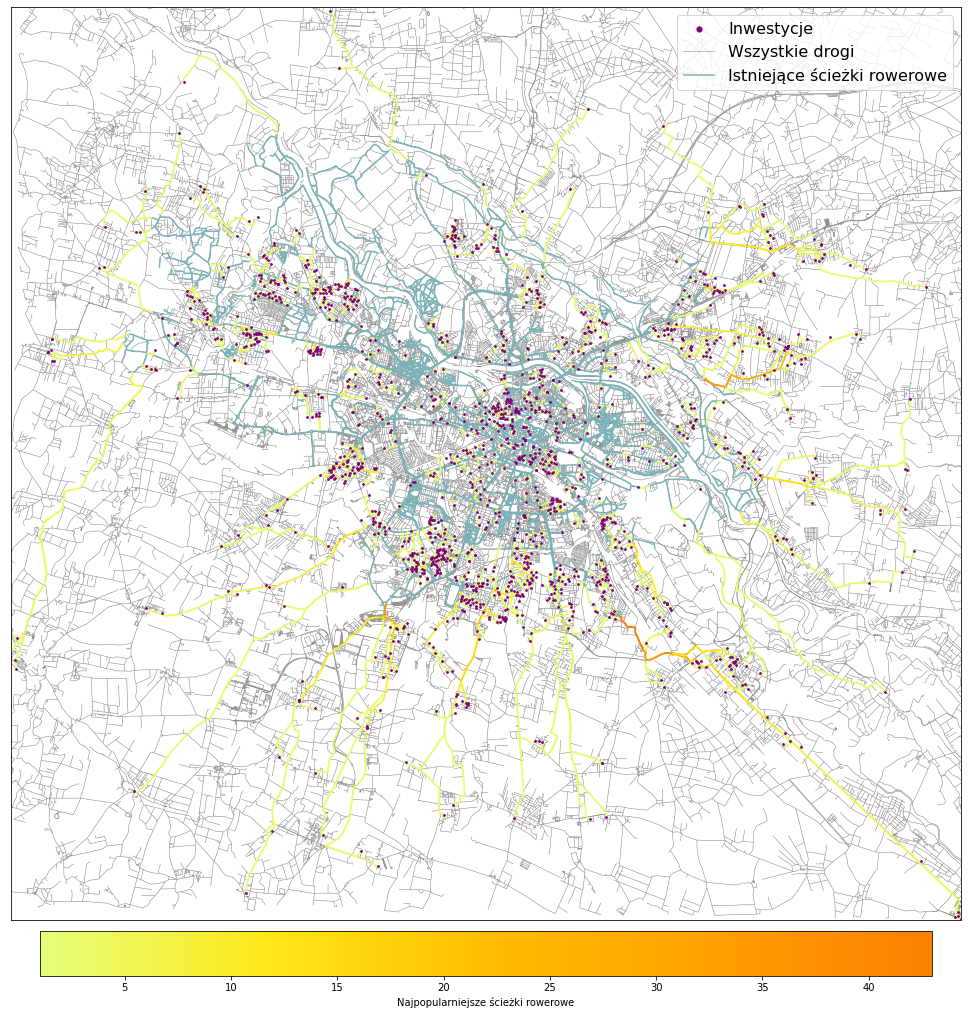

In [52]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot()
G_nodes[G_nodes['type'] == 'building'].plot(
    markersize=3, color='purple', ax=ax, zorder=7, label='Inwestycje'
)

G_streets[G_streets['type'] == 'all_road'].plot(
    ax=ax, alpha=1, linewidth=0.5, edgecolor='gray', label='Wszystkie drogi'
)
G_streets[G_streets['type'] == 'bike_path'].plot(
    ax=ax, alpha=1, linewidth=1.5, edgecolor='#7bb3b8', label='Istniejące ścieżki rowerowe'
)
G_streets[G_streets.get('additional') == 'new_bike_path'].plot(column='bike_counter', linewidth=2, ax=ax, legend=True, cmap='Wistia',
           legend_kwds={'label': "Najpopularniejsze ścieżki rowerowe",
                        'orientation': "horizontal",'pad': 0.01, 'shrink': 0.8} )
ax.legend(markerscale=3, fontsize=16)
plt.rcParams['legend.fontsize'] = 16
ax.set_ylim(bottom=5.6461e6, top=5.6803e6)
ax.set_xlim(left=6.4134e6, right=6.449e6)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
# cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)
plt.savefig('image/bike_counter.png', dpi=400)

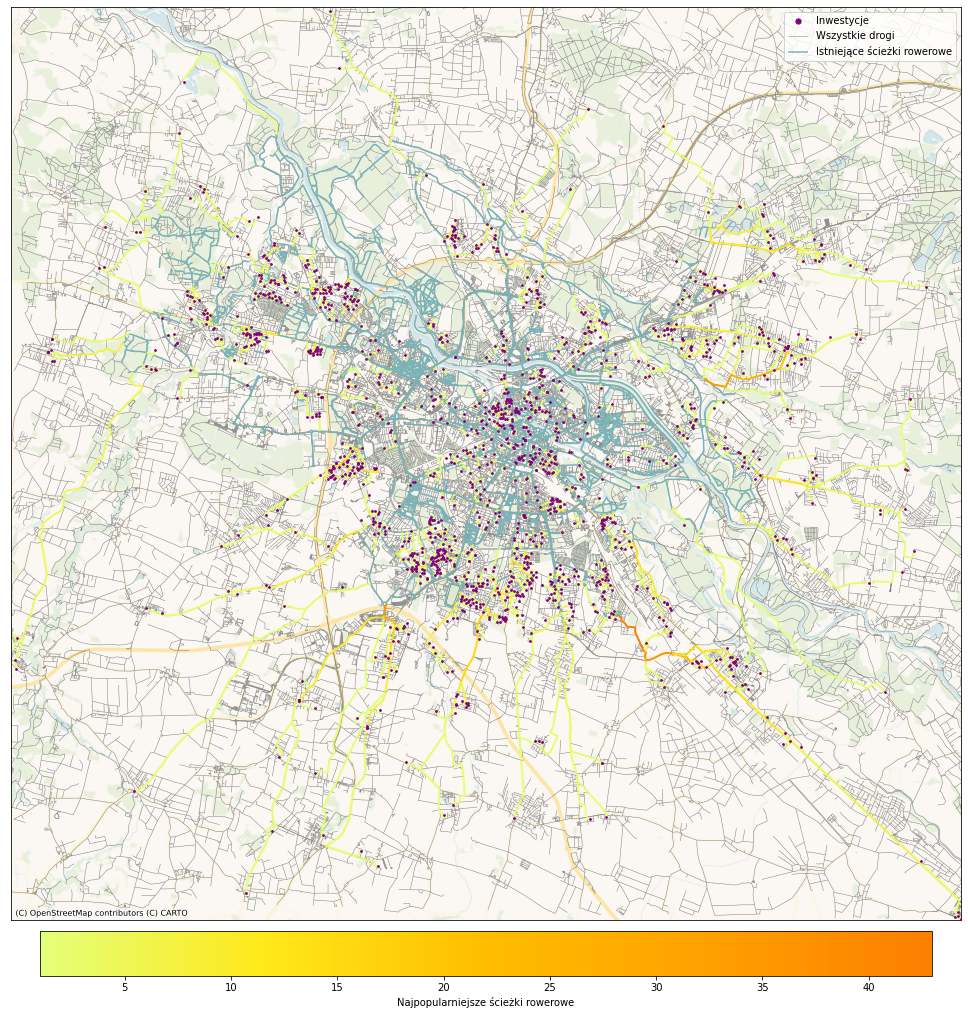

<Figure size 432x288 with 0 Axes>

In [26]:
cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.VoyagerNoLabels)
fig.savefig('image/shortest_paths_adjusted.jpg', dpi=400, bbox_inches='tight')
fig